# Feature extraction

Extract trackster level features as additional features for clustering
- including - total energy

In [74]:
import uproot
import numpy as np
from reco.plotting import plot_event, plot_remapped, plot_tracksters
from reco.evaluation import evaluate
from reco.event import remap_arrays_by_label, remap_items_by_label
from reco.energy import get_total_energy
import matplotlib.pyplot as plt
import awkward as ak

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

%matplotlib inline

# file_name = "~/Data/pions/new_ntuples_14955802_7.root"
file_name = "~/data/multi/new_ntuples_14992862_991.root"


tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

Tracksters reco: 78, tracksters sim: 10
Simulated energy: 3522.02, reconstructed energy: 3123.60 (88.69%)


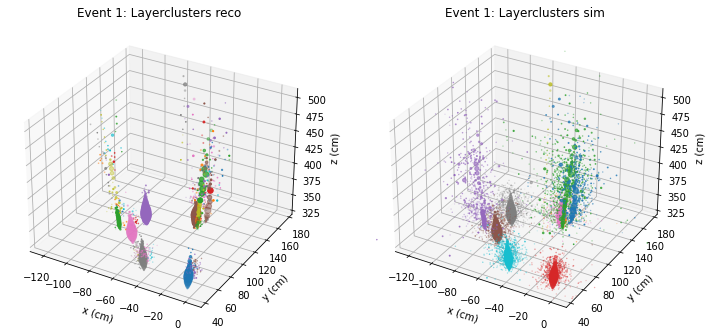

In [75]:
eid = 1

t_indexes = tracksters["vertices_indexes"].array()[eid]
t_energy = tracksters["vertices_energy"].array()[eid]
v_multi = tracksters["vertices_multiplicity"].array()[eid]
st_indexes = simtracksters["stsSC_vertices_indexes"].array()[eid]
st_energy = simtracksters["stsSC_vertices_energy"].array()[eid]
sv_multi = simtracksters["stsSC_vertices_multiplicity"].array()[eid]

K = len(st_indexes)
print(f"Tracksters reco: {len(t_indexes)}, tracksters sim: {K}")

reco_total = get_total_energy(t_energy, v_multi)
sim_total = get_total_energy(st_energy, sv_multi)
print(f"Simulated energy: {sim_total:.2f}, reconstructed energy: {reco_total:.2f} ({(reco_total / sim_total) * 100:.2f}%)")

plot_event(tracksters, simtracksters, eid, legend=False)

In [76]:
precision, recall, fscore = evaluate(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 0.97, Recall: 0.06, F-score: 0.11


In [77]:
def evaluate_remapped(labels):
    ri = remap_arrays_by_label(t_indexes, labels)
    re = remap_arrays_by_label(t_energy, labels)
    rm = remap_arrays_by_label(v_multi, labels)
    precision, recall, fscore = evaluate(ri, st_indexes, re, st_energy, rm, sv_multi, noise=False)
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")
    

In [78]:
pca_components = []

tvx = tracksters["vertices_x"].array()[eid]
tvy = tracksters["vertices_y"].array()[eid]
tvz = tracksters["vertices_z"].array()[eid]

for t_id in range(len(tvx)):
    X = np.array([tvx[t_id], tvy[t_id], tvz[t_id]]).T   # shape: (datapoint, coords)
    if X.shape[0] > 2:                                  # at least two datapoints (LC)
        pca = PCA(n_components=3).fit(X)
        data = pca.transform(X) + pca.mean_[:3]         # (datapoint, coords)
        data = np.hstack((data, np.transpose(
            [t_indexes[t_id], t_energy[t_id]]
        )))
        pca_components.append(data.T)                   # trackster, coord, datapoint

transformed = ak.Array(pca_components)

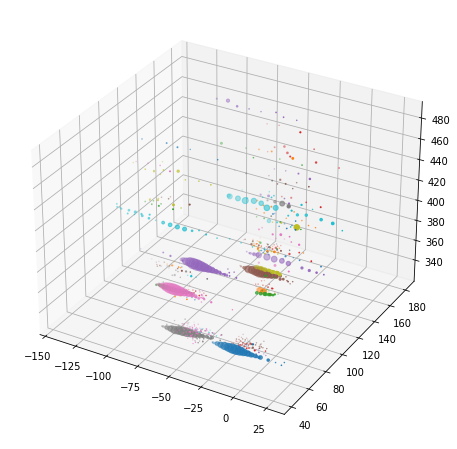

In [79]:
# layerclusters in PCA space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(transformed)):
    ax.scatter(transformed[i,0], transformed[i,1], transformed[i,2], label=i, s=transformed[i,4] * 2)

plt.show()

Perform LC-based clustering in the PCA space

In [80]:
pca_x = ak.flatten(transformed[:,0])
pca_y = ak.flatten(transformed[:,1])
pca_z = ak.flatten(transformed[:,2])
pca_i = ak.flatten(transformed[:,3])
pca_e = ak.flatten(transformed[:,4])

X = np.array([pca_x, pca_y, pca_z]).T

k-means in PCA space

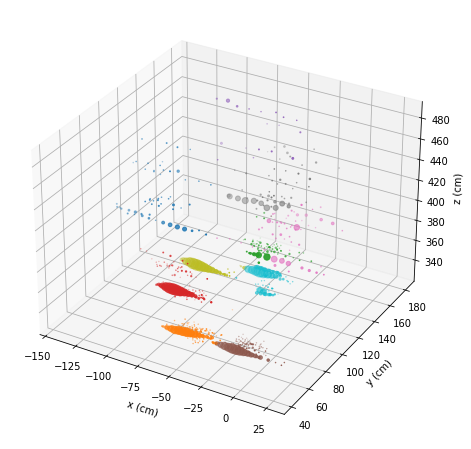

In [81]:
kmeans = KMeans(n_clusters=K, random_state=0).fit(X)
rx = remap_items_by_label(pca_x, kmeans.labels_)
ry = remap_items_by_label(pca_y, kmeans.labels_)
rz = remap_items_by_label(pca_z, kmeans.labels_)
re = remap_items_by_label(pca_e, kmeans.labels_)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plot_tracksters(ax, rx, ry, rz, re)
plt.show()

In [82]:
ri = remap_items_by_label(pca_i, kmeans.labels_)
rm = remap_items_by_label(np.ones(len(pca_e)), kmeans.labels_)

precision, recall, fscore = evaluate(ri, st_indexes, re, st_energy, rm, sv_multi, noise=False)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 0.79, Recall: 0.68, F-score: 0.73


GMM in PCA space

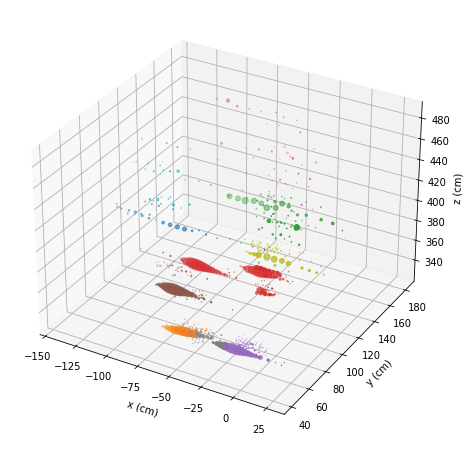

In [83]:
gmm = GaussianMixture(n_components=K, covariance_type='full').fit(X)
gmm_labels = gmm.predict(X)

rx = remap_items_by_label(pca_x, gmm_labels)
ry = remap_items_by_label(pca_y, gmm_labels)
rz = remap_items_by_label(pca_z, gmm_labels)
re = remap_items_by_label(pca_e, gmm_labels)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plot_tracksters(ax, rx, ry, rz, re)
plt.show()

In [84]:
ri = remap_items_by_label(pca_i, gmm_labels)
rm = remap_items_by_label(np.ones(len(pca_e)), gmm_labels)

precision, recall, fscore = evaluate(ri, st_indexes, re, st_energy, rm, sv_multi, noise=False)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 0.60, Recall: 0.53, F-score: 0.56


DBSCAN in PCA space

In [155]:
dbscan = DBSCAN(eps=8, min_samples=7).fit(X)
print("Tracksters:", max(dbscan.labels_)+1)

Tracksters: 12


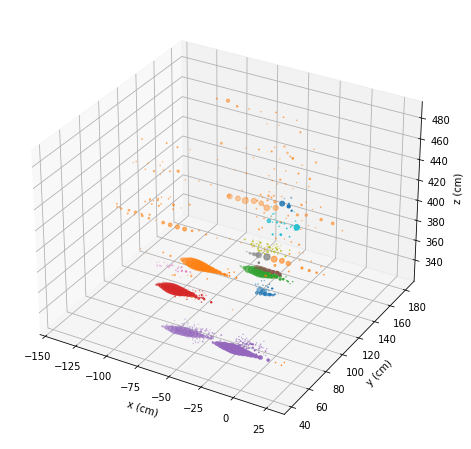

In [156]:
rx = remap_items_by_label(pca_x, dbscan.labels_)
ry = remap_items_by_label(pca_y, dbscan.labels_)
rz = remap_items_by_label(pca_z, dbscan.labels_)
re = remap_items_by_label(pca_e, dbscan.labels_)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plot_tracksters(ax, rx, ry, rz, re)
plt.show()

In [157]:
ri = remap_items_by_label(pca_i, dbscan.labels_)
rm = remap_items_by_label(np.ones(len(pca_e)), dbscan.labels_)

precision, recall, fscore = evaluate(ri, st_indexes, re, st_energy, rm, sv_multi, noise=False)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 0.61, Recall: 0.63, F-score: 0.62
